# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

In [2]:
#Import dataset
boston = pd.read_csv('C:/Users/tvpia/Desktop/FORKS WEEK 8/lab-problems-in-ml/data/boston_data.csv')

boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [3]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
crim       404 non-null float64
zn         404 non-null float64
indus      404 non-null float64
chas       404 non-null float64
nox        404 non-null float64
rm         404 non-null float64
age        404 non-null float64
dis        404 non-null float64
rad        404 non-null float64
tax        404 non-null float64
ptratio    404 non-null float64
black      404 non-null float64
lstat      404 non-null float64
medv       404 non-null float64
dtypes: float64(14)
memory usage: 44.3 KB


In [3]:
boston.shape

(404, 14)

In [8]:
for c in boston.columns:
    print(boston[c].describe()[['min','max','mean','50%']])

min      0.006320
max     88.976200
mean     3.730912
50%      0.253715
Name: crim, dtype: float64
min      0.000000
max     95.000000
mean    10.509901
50%      0.000000
Name: zn, dtype: float64
min      0.460000
max     27.740000
mean    11.189901
50%      9.795000
Name: indus, dtype: float64
min     0.000000
max     1.000000
mean    0.069307
50%     0.000000
Name: chas, dtype: float64
min     0.39200
max     0.87100
mean    0.55671
50%     0.53800
Name: nox, dtype: float64
min     3.56100
max     8.78000
mean    6.30145
50%     6.23050
Name: rm, dtype: float64
min       2.900000
max     100.000000
mean     68.601733
50%      76.600000
Name: age, dtype: float64
min      1.169100
max     12.126500
mean     3.799666
50%      3.207450
Name: dis, dtype: float64
min      1.000000
max     24.000000
mean     9.836634
50%      5.000000
Name: rad, dtype: float64
min     187.000000
max     711.000000
mean    411.688119
50%     330.000000
Name: tax, dtype: float64
min     12.600000
max     22.0

In [10]:
#lets remove outliers from the crim feature since it could cause overfitting
new_boston = boston[(np.abs(stats.zscore(boston.crim)) < 3)]
new_boston.shape

(397, 14)

In [12]:
new_boston.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [7]:
# Outliers cleaned and no missing data

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [13]:
new_boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

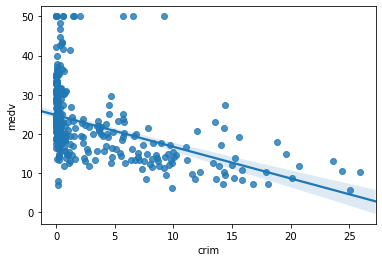

In [14]:
sns.regplot(x='crim',y='medv', data=new_boston)

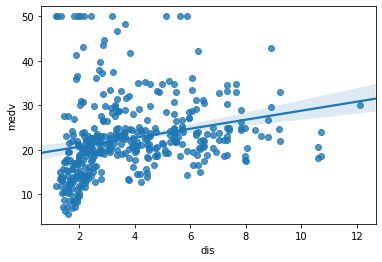

In [15]:
sns.regplot(x='dis', y="medv", data=new_boston)

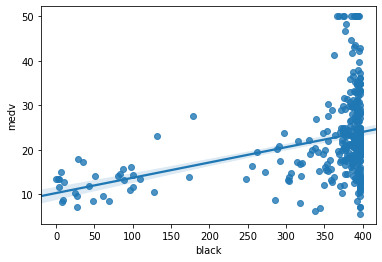

In [17]:
sns.regplot(x='black', y="medv", data=new_boston)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [14]:
#Not what I expected

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

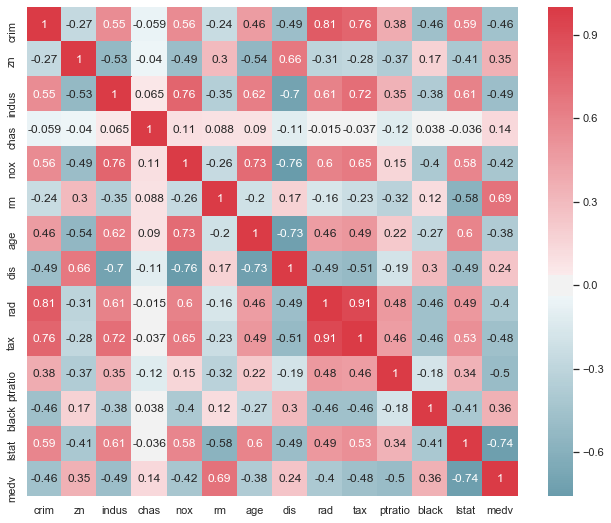

In [19]:
# Your response here

sns.set(color_codes = False)

corr = new_boston.corr()

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, cmap = cmap, center = 0, annot = True)

plt.show()

In [20]:
new_boston.corr().unstack().sort_values(ascending = False).drop_duplicates()

medv  medv     1.000000
rad   tax      0.913829
      crim     0.814357
tax   crim     0.763578
nox   indus    0.757117
                 ...   
rm    lstat   -0.576401
dis   indus   -0.696905
age   dis     -0.730937
medv  lstat   -0.737023
dis   nox     -0.758721
Length: 92, dtype: float64

In [21]:
#The correlation with tax and rad is quite high, not sure if I should drop it
#rad also has a high corr with crim
#Therefore I decided to drop the rad columns (RAD - index of accessibility to radial highways)
new_boston.drop(columns='rad',axis=1, inplace=True)

C:\Users\tvpia\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [23]:
new_boston.medv.describe()[["min","max","mean","median","std"]]

C:\Users\tvpia\Anaconda3\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


min        5.600000
max       50.000000
mean      22.545592
median          NaN
std        8.725822
Name: medv, dtype: float64

In [26]:
new_boston.medv.unique()
#unsure why the median return nan as there are no nans in the column

array([21.7, 19.6, 20.3, 15.4, 20.5, 34.9, 26.2, 21.6, 14.1, 17. , 10.4,
       23.3, 21. , 22.2,  8.7, 23.7, 12. , 21.5,  9.5, 23. , 20.8, 29.4,
       16.5, 16.2, 18.4, 31.1, 21.9, 18.6, 29.1, 36.2, 17.8, 23.1, 50. ,
       29. , 12.7, 35.1, 19.9, 13.8, 23.9, 20.2, 22.6, 19.4, 15.6, 43.1,
       13.4, 13.1, 11.3, 31. , 42.3, 44.8, 25. , 35.2, 24. , 18.2, 10.2,
        7.2, 28.2, 22.9, 34.7, 22. , 22.4, 17.1, 24.1, 19.8, 33.4,  8.5,
       23.2, 16.8, 20.6, 16.4, 43.5, 20. , 13.5, 18.5, 23.4, 35.4, 19.3,
       12.6, 26.6, 32.9, 39.8, 29.6, 30.1, 14. , 24.5, 32.7, 41.3, 28.7,
       19. , 34.6, 20.1, 23.8, 15.1, 16.1, 21.8, 13.9, 30.8, 11.8, 28.4,
       18.9, 21.4, 26.4, 37.2, 24.8, 14.5, 12.3, 17.2, 10.5,  7. , 24.7,
       37.9, 19.1, 24.4, 37.6, 29.8, 12.1, 27.5,  8.8,  8.4, 22.7, 11.9,
       21.1, 15.2, 18.7, 26.5, 11.5, 30.3, 18.8, 28.6, 27. , 33.1, 26.7,
       13.3,  9.7, 36.5, 33.3, 24.6, 11.7, 13. , 15.3,  8.1, 16.7, 23.6,
       32. , 17.3, 15. , 33.2, 20.9, 21.2, 22.3, 19

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [27]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true,y_pred)
    
    
    # Your code here:

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [28]:
# Your code here
X= new_boston.drop("medv",axis=1)
y=new_boston.medv
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state = 67, shuffle=True)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [29]:
k = [2,4,6,8,10]
train=[]
test=[]
for n in k:
    regr = RandomForestRegressor(max_depth=n, random_state=67)
    regr.fit(X_train, y_train)
    train.append(regr.score(X_train,y_train))
    test.append(regr.score(X_test,y_test))

C:\Users\tvpia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tvpia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tvpia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tvpia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\tvpia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Now, plot the score for each tree on the training set and on the testing set.

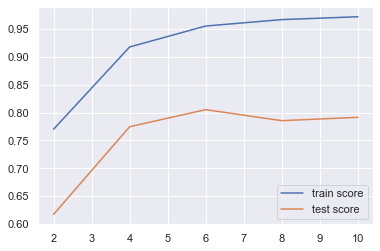

In [30]:
# Produce a plot with the score for the testing and training for the different max depths

plt.plot(k,train,label="train score")
plt.plot(k,test,label='test score')
plt.legend()
  

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [31]:
#The model seems to have the best performance when the max deth is 6

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [32]:
#With a max depth of 1, the bias is low and the variance is high
#When the maximum depth gets higher, the variance goes down

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [ ]:
# 6

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Not relevant anymore, many things may have changed in the city
#The features are still quite relevant to describe a home in my opinion
#No a rural city will probably have much lower prices and we can't apply this model